In [2]:
import pandas as pd
import numpy as np
import re
from scipy import stats
from itertools import chain
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
from itertools import combinations


from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import shapely, geopandas, fiona 
import geopandas as gpd
import descartes
from shapely.geometry import Polygon, Point, MultiPolygon

from matplotlib.path import Path

In [3]:
#load the data frame
DF = pd.read_csv('Data/food-inspections.csv', sep = ',')
DF = DF.drop_duplicates()
df_in = DF.copy()

In [4]:
# drop columns with null values
DF = DF.dropna(subset = ['Violations','Facility Type','Risk','Longitude','Latitude','Zip','AKA Name'])
print(len(DF))

#give new indices to each remaining column
DF.index = range(1,len(DF) + 1)

141909


In [5]:
#obtain year, month and day from date
DF['year'] = DF['Inspection Date'].apply(lambda x:x.split('-')[0])
DF['month'] = DF['Inspection Date'].apply(lambda x:x.split('-')[1])
DF['day'] = DF['Inspection Date'].apply(lambda x:x.split('-')[2])
DF['day'] = DF['day'].apply(lambda x:x.split('T')[0])
DF.head(5)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,year,month,day
1,2345318,SUBWAY,SUBWAY,2529116.0,Restaurant,Risk 1 (High),2620 N NARRAGANSETT AVE,CHICAGO,IL,60639.0,...,-87.785752,"{'latitude': '-87.78575236468352', 'longitude'...",NaN,NaN,NaN,NaN,NaN,2019,11,08
2,2345334,LA MICHOACANA ICE CREAM SHOP,LA MICHOACANA ICE CREAM SHOP,2698396.0,Restaurant,Risk 1 (High),3591-3597 N MILWAUKEE AVE,CHICAGO,IL,60641.0,...,-87.735183,"{'latitude': '-87.73518301995274', 'longitude'...",NaN,NaN,NaN,NaN,NaN,2019,11,08
3,2345339,THE CREPE SHOP,THE CREPE SHOP,2699005.0,Restaurant,Risk 1 (High),2934 N BROADWAY,CHICAGO,IL,60657.0,...,-87.644407,"{'latitude': '-87.64440716256712', 'longitude'...",NaN,NaN,NaN,NaN,NaN,2019,11,08
4,2345319,GOPUFF,GOPUFF,2684558.0,Grocery Store,Risk 3 (Low),1801 W WARNER AVE,CHICAGO,IL,60613.0,...,-87.674395,"{'latitude': '-87.6743946694658', 'longitude':...",NaN,NaN,NaN,NaN,NaN,2019,11,08
5,2345217,"LUNA PARK, INC.",LUNA PARK DAY CARE,2215485.0,Children's Services Facility,Risk 1 (High),3250 W FOSTER AVE,CHICAGO,IL,60625.0,...,-87.710746,"{'latitude': '-87.7107455232781', 'longitude':...",NaN,NaN,NaN,NaN,NaN,2019,11,07


## Violation parsing

In [6]:
from itertools import combinations

In [7]:
df_vio = df_in.dropna(subset=['Risk'])
df_vio = df_vio[df_vio['Risk'] != 'All']

In [8]:
def Find_vionumber(vio):
    vionum = []
    if pd.isna(vio) == False:
        for i in vio.split(' | '):
            n = re.findall('([0-9]+)',i[0:4])
            vionum = list(set(vionum).union(set(n)))
    return vionum

In [9]:
def expand_varible(vio):
    var = np.zeros(64)
    if vio !=[]:
        for i in vio:
            n = int(i)-1
            if n == 69:
                n = 63
            var[n] = 1
    return var

In [10]:
#extract the numbering of violations
df_vio['Violation_num'] = df_vio['Violations'].apply(lambda x :Find_vionumber(x))


In [11]:
#get the over all violation list
violation_list = []
for i in df_vio["Violation_num"]:
    violation_list = list(set(violation_list).union(set(i)))
violation_list.sort()

In [12]:

df_vio['Violation_vector'] = df_vio['Violation_num'].apply(lambda x:expand_varible(x))

In [13]:
vio_adj = np.zeros([len(violation_list),len(violation_list)])
for i in df_vio['Violation_num']:
    if i != []:
        
        for j in combinations(i, 2):
            m = int(j[0])-1
            n = int(j[1])-1
            if m == 69:
                m = 63
            if n == 69:
                n = 63
            vio_adj[m][n] = vio_adj[m][n]+1
        for d in i:
            d = int(d)-1
            if d == 69:
                d = 63
            vio_adj[d][d] = vio_adj[d][d]+1
            
            

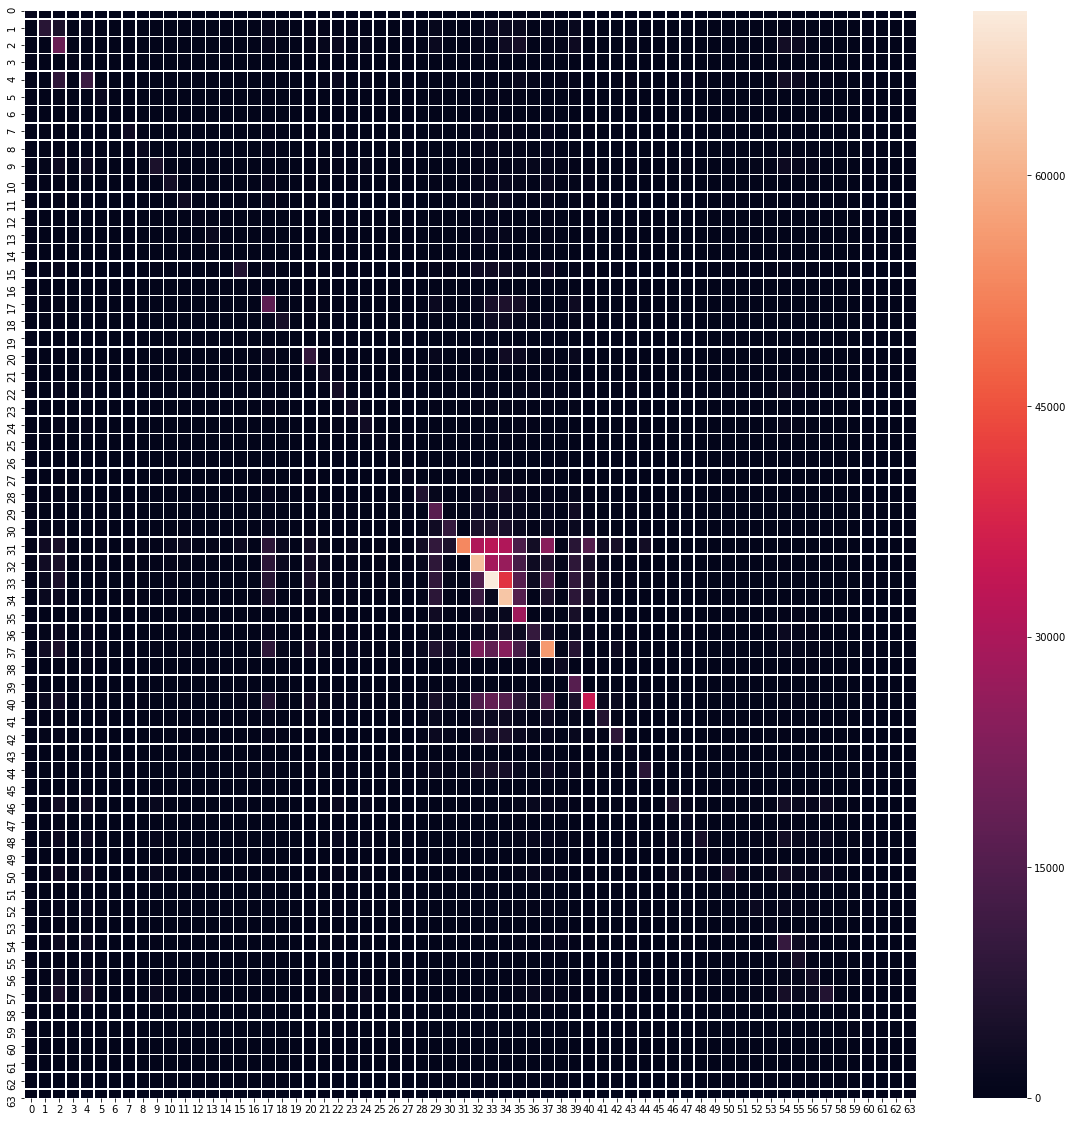

In [14]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(vio_adj,linewidths=.5, ax=ax)

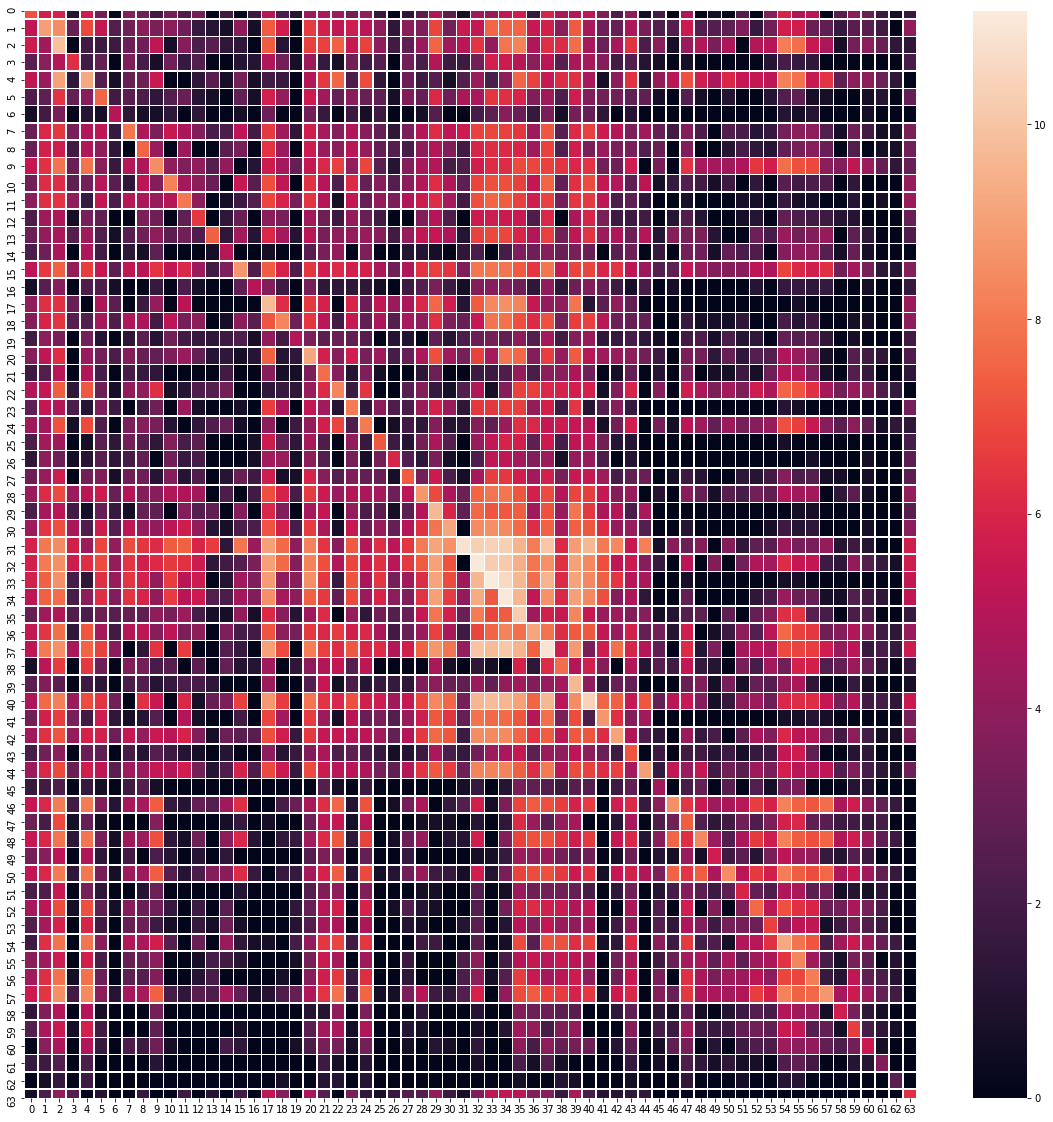

In [15]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(np.log(vio_adj+1), linewidths=.5, ax=ax)

Above two pictures are the the heatmap of the adjacency matrix of violations. The first one is the heatmap drawn directly by the times of the co-appears of violations, while sice the distribution interval of the number of co appears is too large,it's hard to see the differences between low values. So we take the log of (co-appeared times plused one) as the value of hetmaps so that we can see differences better of low values.

We can see that although there are lot of co-appear pairs, some of theme appeared extrodinary more often than others. We don't have a clear clue yet, but we think that it has some relation with the inspection type, we will try to figure it in further research.

In [16]:
vio_matrix = np.reshape(np.concatenate((df_vio['Violation_vector'].values),axis = 0),(df_vio.shape[0],len(violation_list)))

In [17]:
# compute the correlation between violations to extract the most related violations
corr_vio = np.corrcoef(vio_matrix.T)

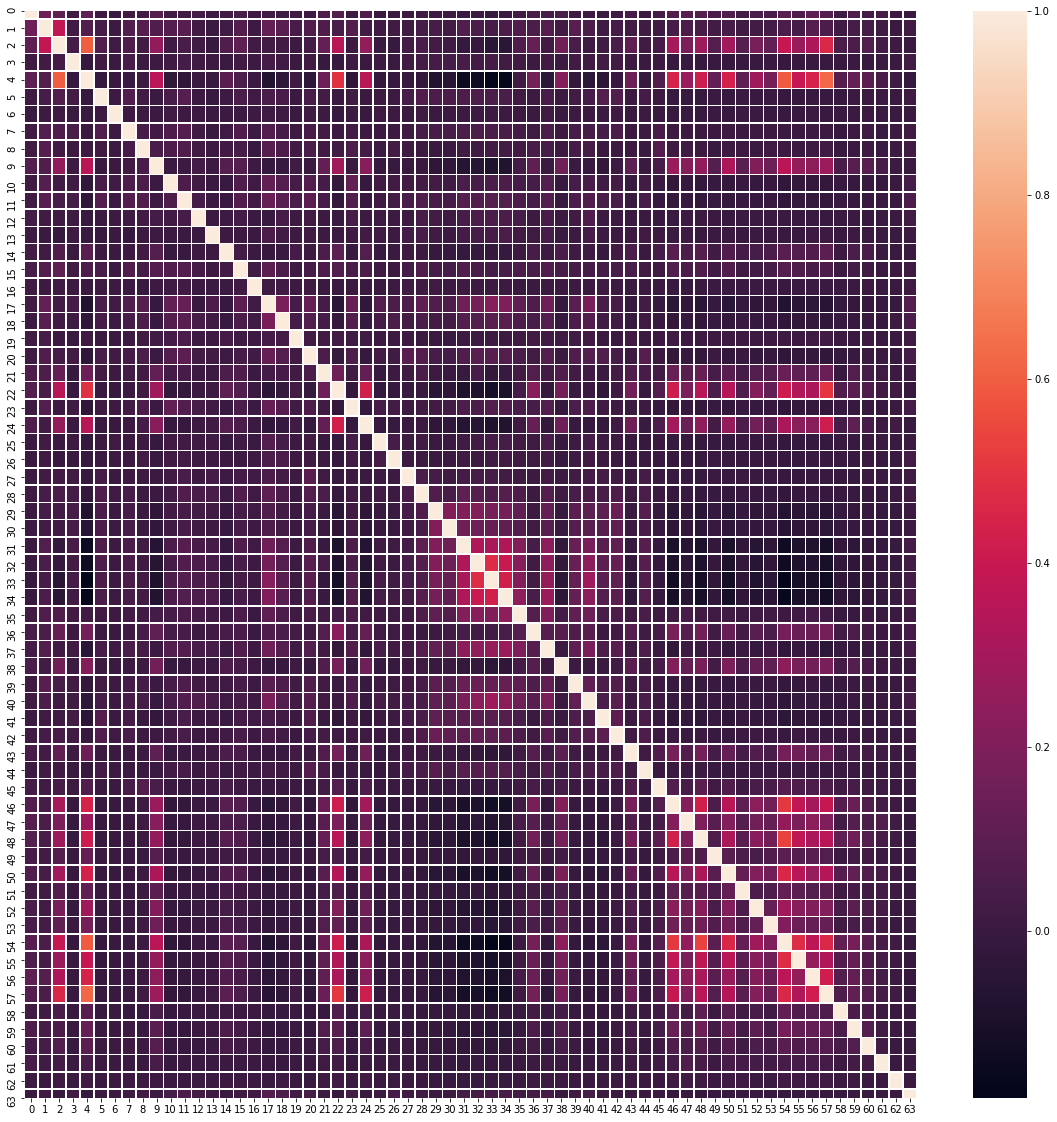

In [20]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(corr_vio,linewidths=.5, ax=ax)


Too see better the relations between violations, we also comput the correlations between violations, we can see that most violations that appeared toghter do have a larger correlation value than the others. But there are some high frequently appeared violations have a smaller correlation value than others, for this vio pairs, we will do some more detailed research in further working. 

### input importance analysis

#### Using logistic regression

consider violation as the input we want to find out which violations are the most inportant violations

In [21]:
import sklearn
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split

In [22]:
risk_labels = df_vio['Risk'].apply(lambda x:x[5]) 
risk_labels = risk_labels.values

In [23]:
import numpy as np
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# depart the trainning set and test set
X_train, X_test, Y_train, Y_test = train_test_split(vio_matrix, risk_labels, test_size=0.1, random_state=0)


# train the model
logreg = linear_model.LogisticRegression(C=1000)
logreg.fit(X_train, Y_train)

# # predict 
# prepro = logreg.predict_proba(X_test)
acc = logreg.score(X_test,Y_test)
acc

D:\anaconda3\envs\ada\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\anaconda3\envs\ada\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.721230107967047

In [24]:
logreg.coef_ [0]#not sure how to use it

array([-0.12854432, -0.20992991,  0.52100343,  0.24324981, -1.02725477,
        0.2210455 , -0.1316008 ,  0.92167624, -0.42517624, -0.03769671,
       -0.20445416, -0.13202881, -0.37293558,  0.06324986,  1.30244797,
        0.28882517,  0.34198583, -0.33119828, -0.25710414, -0.84424066,
       -0.42441486,  0.02961622,  1.07210082, -0.14392795,  1.51883106,
        0.00510736,  0.15025376, -0.38975282,  0.49104874,  0.74555516,
        0.86803611,  0.34466335,  0.17558717, -0.02413208,  0.2282117 ,
        0.04657806, -0.38935451,  0.20091561,  0.23281805, -0.07885743,
       -0.21043783,  0.0122158 ,  0.3919036 ,  0.48958598,  0.29741126,
       -0.66403159,  0.24908329, -0.13227037, -0.04656104, -0.66623981,
        0.18884672, -0.17721681, -0.12894378, -0.27462282,  0.30370025,
        0.229611  , -0.63954785,  3.46174589,  0.68726296,  1.72345511,
       -0.55734519, -0.02866463, -0.4392175 , -0.73773078])

For the logistic regression ,we want to obtain the importance of violations by looking at the weight assingned to different violation types.

#### Using Random Forest

We also used random forest to obtain the importances of the violations.

In [25]:
# from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
x = vio_matrix
y = risk_labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
feat_labels = list(range(1,65))
forest = RandomForestClassifier(n_estimators=100,oob_score=True, random_state=0 , n_jobs=-1)
forest.fit(x_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [26]:
acc = forest.score(X_test,Y_test)
importances = forest.feature_importances_

##### Importance result

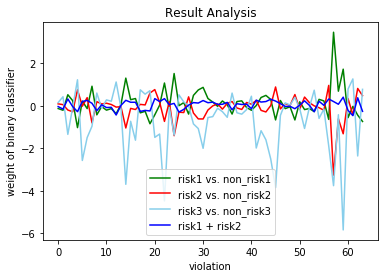

In [27]:
importances = forest.feature_importances_


plt.title('Result Analysis')
plt.plot(logreg.coef_ [0], color='green', label='risk1 vs. non_risk1')
plt.plot(logreg.coef_ [1],color='red', label='risk2 vs. non_risk2')
plt.plot(logreg.coef_ [2],  color='skyblue', label='risk3 vs. non_risk3')
plt.plot((logreg.coef_ [1]+logreg.coef_ [0]), color='blue', label='risk1 + risk2')
plt.legend() # 显示图例

plt.xlabel('violation')
plt.ylabel('weight of binary classifier')
plt.show()




For a 3-class classification problem in  logistic regression,it turned into 3 binary classification problems, so we have 3 groups of weight for input feature (violations).Each group of weights is the weights of binary classifier "risk x vs. norisk x".

From the weight we get, we can see that violations around No.55 have significant influential to the all the tree binary classification. 

Another thing we obtained interesting is that the weight of (risk1 + risk2) have small fluctuations and are always around zero, and the violations assigned with a large weight to Risk3 classification are not so important to risk1 and risk2.

It might because that all the facility with a good condition(risk3) are very sensitive to all kinds of violations.

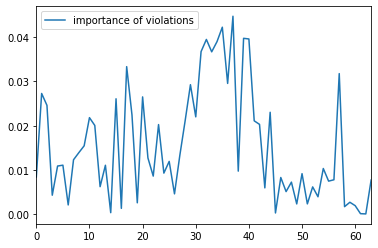

In [28]:
pd.DataFrame(importances,columns = (['importance of violations'])).plot()

Importances got from RF classification didn't match the weights that we got from logisit regression so well,violations from N0.30 to No.40 have extram high importance value from RF classigier while around '0' value of weight from logistic regression classifier.

And also these violations with high importance value are the violations that appeard the most time.We haven't figure it out why, so we are going to do more analysis on this question later in the further.

## Inspections number counted by year, month, result, facility type and inspection type

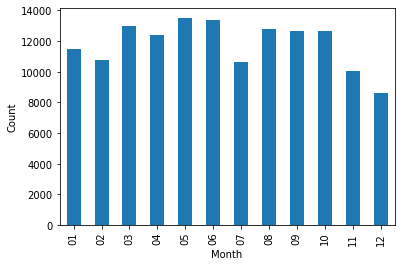

In [29]:
#numbers of inspections by month
mcounts = DF.month.value_counts()
mcounts = mcounts.sort_index()
plt.xlabel('Month');plt.ylabel('Count')
mcounts.plot.bar()

The numbers of inspections per month generally range between 10,000 to 14,000. Inspections in July, November and December are less frequent than they are in spring and autumn. This is probably because of extreme weather hinders the progress of inspections.

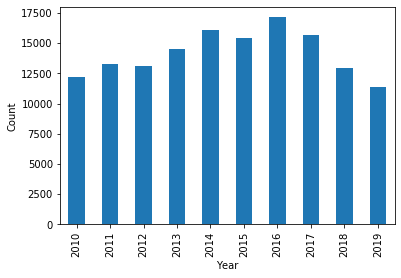

In [30]:
#numbers of inspections by year
ycounts = DF.year.value_counts()
ycounts = ycounts.sort_index()
plt.xlabel('Year');plt.ylabel('Count')
ycounts.plot.bar()

30 to 40 inspections take place per day on average. From 2010 to 2016, the numbers of inspections per year increase by about 30%. However, since 2016, such numbers rapidly decrease to the level of 2010. But it is worth noticing that the data of year 2019 is still being updated, meaning that this decreasing trend might not continue in this year.

<BarContainer object of 3 artists>

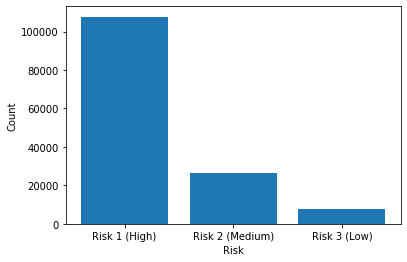

In [31]:
#numbers of inspections by risk
risk = DF.Risk.value_counts().index
rcounts = DF.Risk.value_counts()
plt.xlabel('Risk');plt.ylabel('Count')
plt.bar(risk,rcounts)

Unfortunately, most of the facilities inspected fall in the high risk category. It seems that the food security conditions are really critical in Chicago. On the other hand, if the criterion of inspections is set at a relatively high level in Chicago, Chicago's food security may not be that bad. 
Still, it might not be reasonable to place so many facilities in one category. Spliting the current 3 levels of risks into more levels can provide us with more precise information of risks.

([<matplotlib.patches.Wedge at 0x27881f4bf48>,
 [Text(-0.7999651738761493, 0.7550203444843737, 'Risk 1 (High)'),
  Text(0.66342139948008, -0.8774235275577538, 'Risk 2 (Medium)'),
  Text(1.0847151025054809, -0.18273791723811528, 'Risk 3 (Low)')])

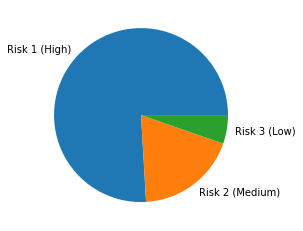

In [32]:
plt.pie(x = rcounts,labels = risk)

Restaurant                      97938
Grocery Store                   17651
School                          10349
Children's Services Facility     2350
Bakery                           2163
Name: Facility Type, dtype: int64


<BarContainer object of 6 artists>

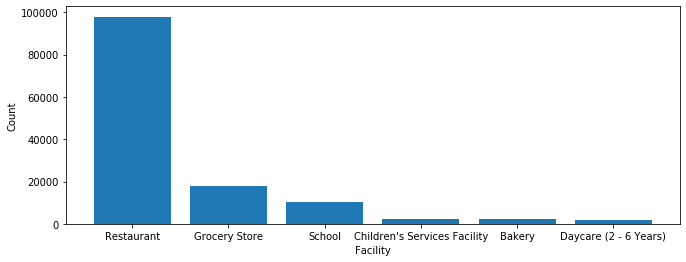

In [33]:
#numbers of inspections by facility
facility = DF['Facility Type'].value_counts().index
fcounts = DF['Facility Type'].value_counts()
print(fcounts.head())

fig = plt.figure(figsize=(11,4))
plt.xlabel('Facility');plt.ylabel('Count')
plt.bar(facility[0:6],fcounts.head(6))

The types are facilities are surprisingly various, but there are only a few common types of facilities: Nearly 100,000 out of 140,000 facilities are identified as 'Restaurant'. Grocery store and school are also common facilities. These three types of facilities account for about 90% of all facilities, while the long tails of other facilities form the rest 10%.

([<matplotlib.patches.Wedge at 0x27882002f88>,
 [Text(-0.7118528945782329, 0.8386092394438494, 'Restaurant'),
  Text(0.26873413421955883, -1.0666686294746202, 'Grocery Store'),
  Text(0.8596765051887602, -0.6862625637658226, 'School'),
  Text(1.0220380960184783, -0.40674086380264757, "Children's Services Facility"),
  Text(1.0589836033332096, -0.29757978404355934, 'Bakery'),
  Text(1.0820961931223974, -0.19765583429288236, 'Daycare (2 - 6 Years)'),
  Text(1.0949923496293101, -0.10484156739234174, 'Daycare Above and Under 2 Years'),
  Text(1.099609712189886, -0.029299843987228246, 'Long Term Care')])

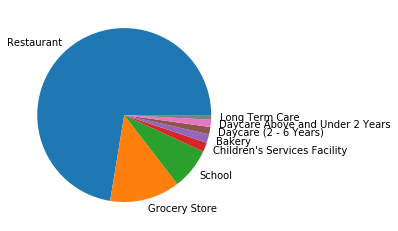

In [34]:
plt.pie(x = fcounts.head(8),labels = facility[0:8])

<BarContainer object of 6 artists>

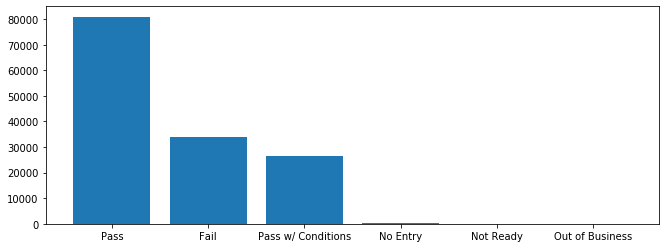

In [35]:
#numbers of inspections by results
result = DF['Results'].value_counts().index
rscounts = DF['Results'].value_counts()
fig = plt.figure(figsize=(11,4))
plt.bar(result,rscounts)

Even though most of the facilities in Chicago are given 'Risk 1' labels, more than 70% of all facilities still manage to pass the inspections. Later, we will discuss its changes throughout the years.

Canvass                     78326
Complaint                   16869
License                     15328
Canvass Re-Inspection       14780
Complaint Re-Inspection      5326
Short Form Complaint         4870
License Re-Inspection        3644
Suspected Food Poisoning      815
Name: Inspection Type, dtype: int64


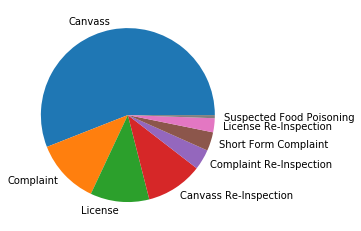

In [36]:
#numbers of inspections by inspection types
inspect_type = DF['Inspection Type'].value_counts().index
ins_counts = DF['Inspection Type'].value_counts()
plt.pie(x = ins_counts.head(8),labels = inspect_type[0:8])
print(ins_counts.head(8))

Most of the inspections are among canvass, complaint, license and their re-inspections. The re-inspection ratio of complaint is the highest, possibly meaning that if a facility is inspected because of complaint, that facility is more likely to be of lower food security quality or to face stricter inspections.  

## Results, Inspection Types and Risks by year and month

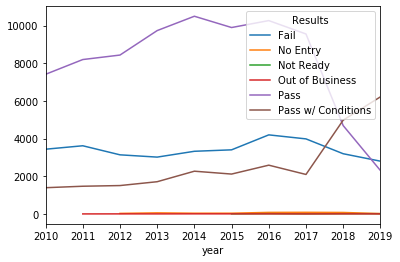

In [37]:
#numbers of each risk in each year
DF_yearisk = DF.groupby(['year','Results'])['Inspection ID'].agg('count').unstack('Results')
DF_yearisk.plot()

In the first few years(2010-2016), are kinds of results slightly increase in similar ways. After 2017, the numbers of inspections with result pass falls, while more facilities are given the result pass with conditions. It is probably because of new policies that encourage inspectors to give conditions for passing.

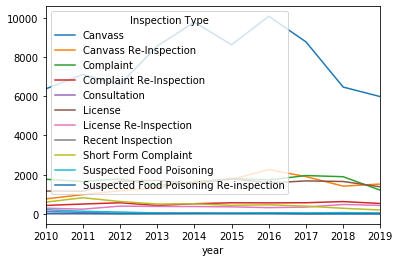

In [38]:
DF_Ins_count = DF.groupby(['year','Inspection Type'])['Inspection ID'].agg('count').unstack('Inspection Type')
DF_Ins_count_new = DF_Ins_count.dropna(axis=1,how='any')
DF_Ins_count_new.plot()

Considering the overall numbers of inspections, the proportions of inspection types are generally constant. 

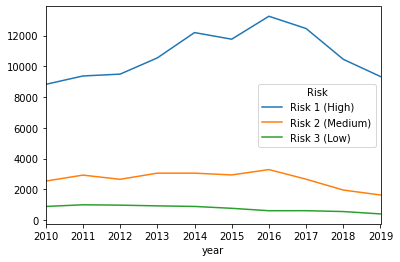

In [39]:
#numbers of each risk in each year
DF_yearisk = DF.groupby(['year','Risk'])['Inspection ID'].agg('count').unstack('Risk')
DF_yearisk.plot()

Likewise, the numbers of Risk 1 change with total numbers of inspections. In contrast, the numbers of Risk 3 slowly decrease regardless of a rise in overall numbers of inspections before 2016.

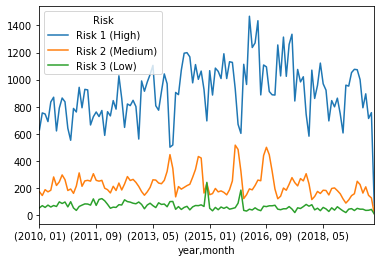

In [40]:
DF_risk = DF.groupby(['year','month','Risk'])['Inspection ID'].agg('count').unstack('Risk')
DF_risk.plot()

The fluctuation of the numbers of each risk per month is much greater than that per year. The graph above shows that risks fluctuate with a period of approximately one year. Therefore, the risks distribution can be unevenly distributed by month.

Risk,Risk 1 (High),Risk 2 (Medium),Risk 3 (Low)
month,,,
01,9538,1419,525
02,8740,1572,441
03,10463,1977,534
04,10017,1828,532
05,10676,2203,629
06,10513,2314,538
07,7907,2163,576
08,9413,2647,711
09,9193,2861,630


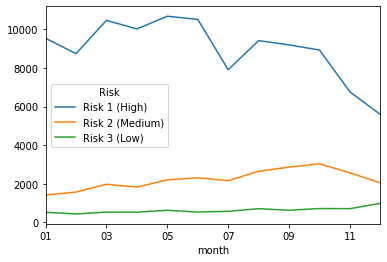

In [41]:
DF_monthrisk = DF.groupby(['month','Risk'])['Inspection ID'].agg('count').unstack('Risk')
DF_monthrisk.plot()
DF_monthrisk

The results of risks of facilities are quite different in different months. The numbers of facilities that are given Risk 1 in December are almost 50% less than the numbers of facilities that are given Risk 1 in January. On the contrary, facilities are more likely to get results of medium and low risks in November and December.

## Geographical Distribution of Risks and Results 

In [42]:
df_geo = df_in.dropna(subset=['Latitude','Longitude'])
# dist = gpd.read_file('Neighborhoods_2012/neighbors_shp.shp')

In [43]:
dist = gpd.read_file('Neighborhoods_2012/neighbors_shp.shp')

In [44]:
df_geo['cor'] = list(zip(df_geo.Longitude,df_geo.Latitude))
df_geo['cor']= df_geo['cor'].apply(Point)
gdf_geo = gpd.GeoDataFrame(df_geo,geometry = 'cor')


D:\anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [45]:
geo_withdist = geopandas.sjoin(gdf_geo, dist, how="inner", op='intersects')


D:\anaconda3\envs\ada\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [46]:
df_geo = pd.DataFrame(geo_withdist)
# df_geo.to_csv("with_district.csv")

In [47]:
from fiona.crs import from_epsg,from_string

In [48]:
#Drop The Date 
gdf_new = geo_withdist.copy()
gdf_new.isnull().sum()
gdf_new = gdf_new[gdf_new['License #'] != 0.0]

In [59]:
gdf_new.crs = {'init':'epsg:4326'}
dist.crs = {'init':'epsg:4326'}

In [60]:
gdf_new.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Results', 'Violations', 'Latitude', 'Longitude',
       'Location', 'Historical Wards 2003-2015', 'Zip Codes',
       'Community Areas', 'Census Tracts', 'Wards', 'cor', 'index_right',
       'PRI_NEIGH', 'SEC_NEIGH', 'SHAPE_AREA', 'SHAPE_LEN'],
      dtype='object')

To do the analysis of with geo-related information, we are going to only ramain the newest inspection risk results as the risk condition for these facilities.

In [61]:
# only remain the newest inspction risk result
gdf_new.sort_values(by='Inspection Date',ascending = False, inplace=True)
gdf_new = gdf_new.groupby(['License #']).head(1)# only take the newest facility inspection risk evaluation


In [62]:
gdf_risk3 = gdf_new[gdf_new['Risk'] == 'Risk 3 (Low)'   ]
gdf_risk2 = gdf_new[gdf_new['Risk'] == 'Risk 2 (Medium)']
gdf_risk1 = gdf_new[gdf_new['Risk'] == 'Risk 1 (High)'  ]

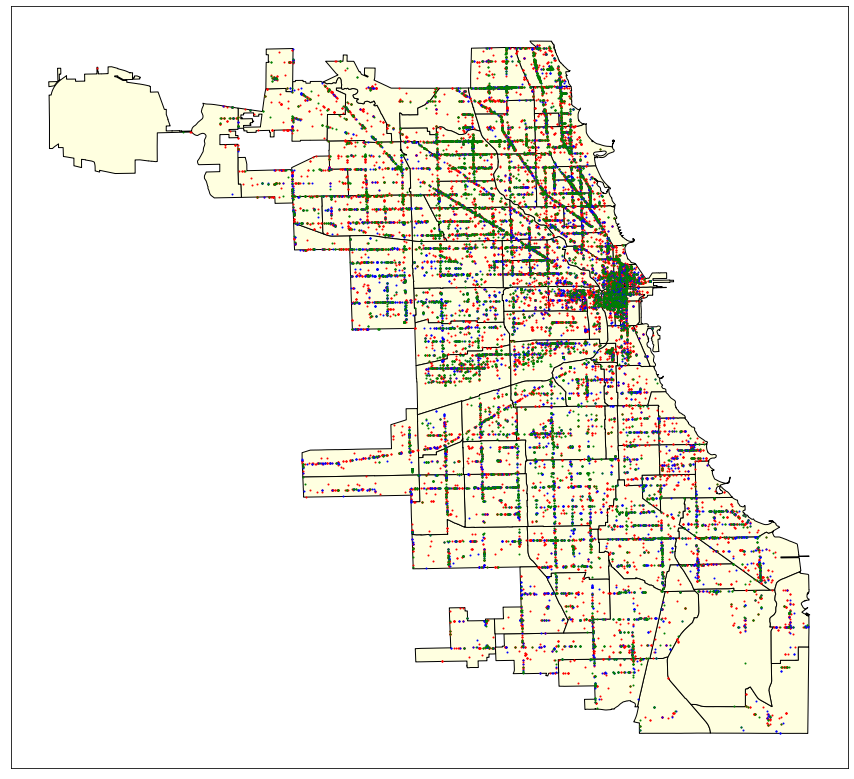

In [63]:
base = dist.plot(color='lightyellow',edgecolor='black',figsize=(15, 15)) 
gdf_risk1.plot(ax=base,marker='o', color='red', markersize=1)
gdf_risk2.plot(ax=base,marker='o', color='blue', markersize=1) 
gdf_risk3.plot(ax=base,marker='o', color='green', markersize=1) 

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())



This is the facility with different risk values distributed in Chicago:
1. green -- Low risk
2. blue  -- Medium risk
3. red   -- High risk

In [64]:
def wgs84_to_CGCS2000(df,code):
    result = df.to_crs(from_epsg(code))
    return result

gdf_new_pcs = wgs84_to_CGCS2000(gdf_new,3435)
risk1_pcs = wgs84_to_CGCS2000(gdf_risk1,3435)
risk2_pcs = wgs84_to_CGCS2000(gdf_risk2,3435)
risk3_pcs = wgs84_to_CGCS2000(gdf_risk3,3435)
dist_pcs = wgs84_to_CGCS2000(dist,3435)

In [65]:
gdf_risk1_buffer = risk1_pcs.buffer(400) 
gdf_risk2_buffer = risk2_pcs.buffer(400) 
gdf_risk3_buffer = risk3_pcs.buffer(400) 

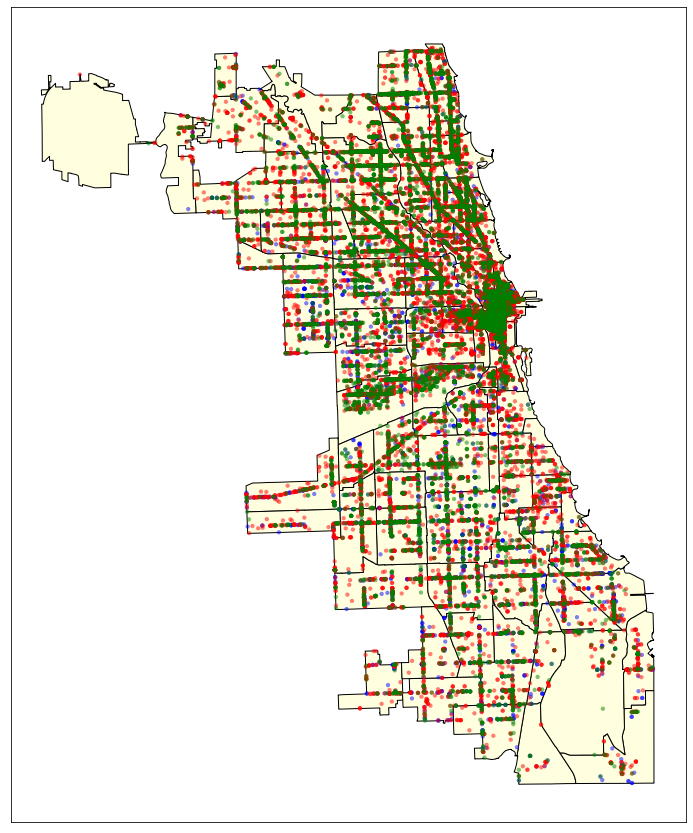

In [67]:

# Geo_in_1_buffer[0]
base = dist_pcs.plot(color='lightyellow',edgecolor='black',figsize=(15, 15))
gdf_risk2_buffer.plot(ax=base,color='blue', markersize=5,alpha=0.5)
gdf_risk1_buffer.plot(ax=base,color='red', markersize=5,alpha=0.5)
gdf_risk3_buffer.plot(ax=base,color='green', markersize=5,alpha=0.5)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator()) 
# plt.savefig('./map2.png',dpi=400) 

In [68]:
risk1_count = gpd.GeoDataFrame(gdf_risk1['PRI_NEIGH'].value_counts()).reset_index()
risk1_count.columns = ['PRI_NEIGH','Risk1']
risk2_count = gpd.GeoDataFrame(gdf_risk2['PRI_NEIGH'].value_counts()).reset_index()
risk2_count.columns = ['PRI_NEIGH','Risk2']
risk3_count = gpd.GeoDataFrame(gdf_risk3['PRI_NEIGH'].value_counts()).reset_index()
risk3_count.columns = ['PRI_NEIGH','Risk3']


In [69]:
dist_risk = dist.copy()
dist_risk = dist_risk.merge(risk1_count,on = 'PRI_NEIGH')
dist_risk = dist_risk.merge(risk2_count,on = 'PRI_NEIGH')
dist_risk = dist_risk.merge(risk3_count,on = 'PRI_NEIGH')

In [70]:
dist_risk['count'] = dist_risk['Risk1'] + dist_risk['Risk2']+dist_risk['Risk3']
dist_risk['mean'] = dist_risk['Risk1']+2*dist_risk['Risk2']+3*dist_risk['Risk3']
dist_risk['mean'] = dist_risk['mean']/dist_risk['count']
dist_risk['variance'] = dist_risk['Risk1']*(1 - dist_risk['mean'])*(1 - dist_risk['mean']) + dist_risk['Risk2']*(2 - dist_risk['mean'])*(2 - dist_risk['mean']) + dist_risk['Risk3']*(3 - dist_risk['mean'])*(3 - dist_risk['mean'])
dist_risk['variance'] = dist_risk['variance']/dist_risk['count']

In [71]:
dist_risk

,PRI_NEIGH,SEC_NEIGH,SHAPE_AREA,SHAPE_LEN,geometry,Risk1,Risk2,Risk3,count,mean,variance
0,Grand Boulevard,BRONZEVILLE,4.849250e+07,28196.837157,"POLYGON ((-87.60671 41.81681, -87.60670 41.816...",129,63,41,233,1.622318,0.586970
1,Printers Row,PRINTERS ROW,2.162138e+06,6864.247156,"POLYGON ((-87.62761 41.87437, -87.62760 41.873...",21,6,7,34,1.588235,0.653979
2,United Center,UNITED CENTER,3.252051e+07,23101.363745,"POLYGON ((-87.66707 41.88885, -87.66707 41.888...",171,106,103,380,1.821053,0.689030
3,Sheffield & DePaul,SHEFFIELD & DEPAUL,1.048259e+07,13227.049745,"POLYGON ((-87.65833 41.92166, -87.65835 41.922...",124,37,27,188,1.484043,0.536979
4,Humboldt Park,HUMBOLDT PARK,1.250104e+08,46126.751351,"POLYGON ((-87.74060 41.88782, -87.74060 41.887...",345,199,226,770,1.845455,0.717674
...,...,...,...,...,...,...,...,...,...,...,...
92,Ukrainian Village,UKRAINIAN VILLAGE AND EAST VILLAGE,1.062239e+07,13311.469796,"POLYGON ((-87.67705 41.89591, -87.67748 41.895...",101,22,25,148,1.486486,0.587655
93,Old Town,OLD TOWN,1.984800e+07,17905.728676,"POLYGON ((-87.63612 41.91847, -87.63569 41.917...",224,58,69,351,1.558405,0.639751
94,Gold Coast,GOLD COAST,7.165706e+06,13685.479377,"POLYGON ((-87.62646 41.91147, -87.62640 41.911...",88,6,30,124,1.532258,0.732830
95,Boystown,BOYSTOWN,3.365779e+06,9780.268985,"POLYGON ((-87.64878 41.93999, -87.64927 41.939...",64,25,25,114,1.657895,0.663666


Text(0.5, 1, "Variance of facilities' risk in different districts")

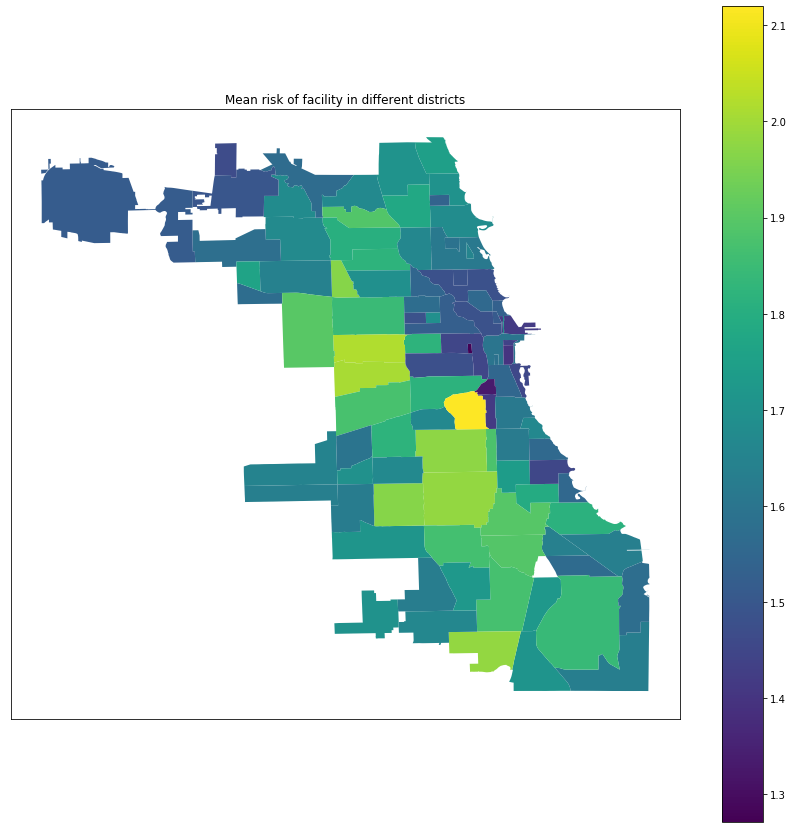

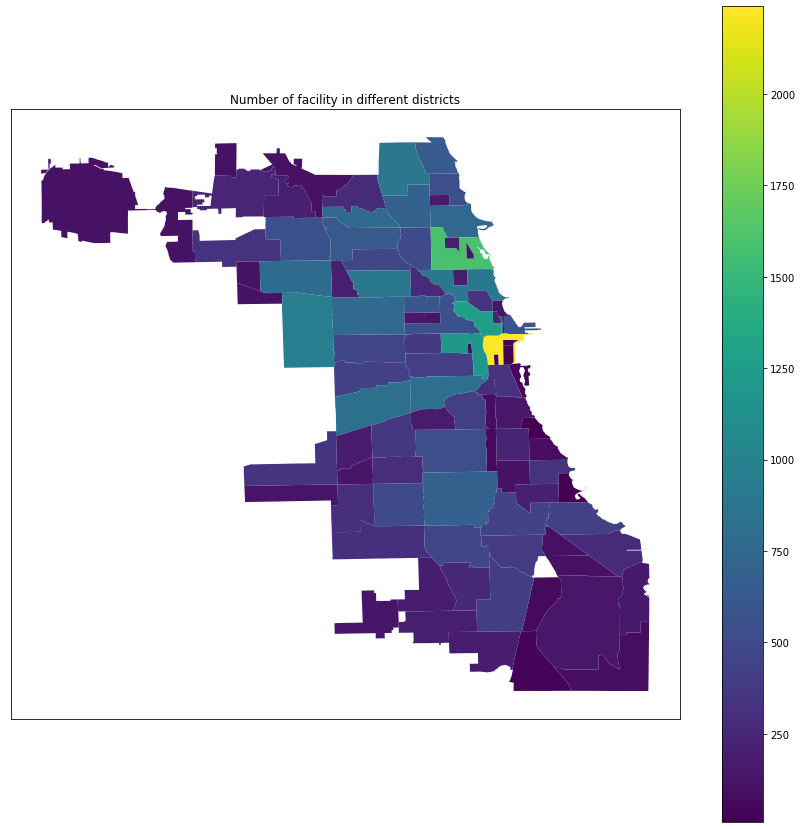

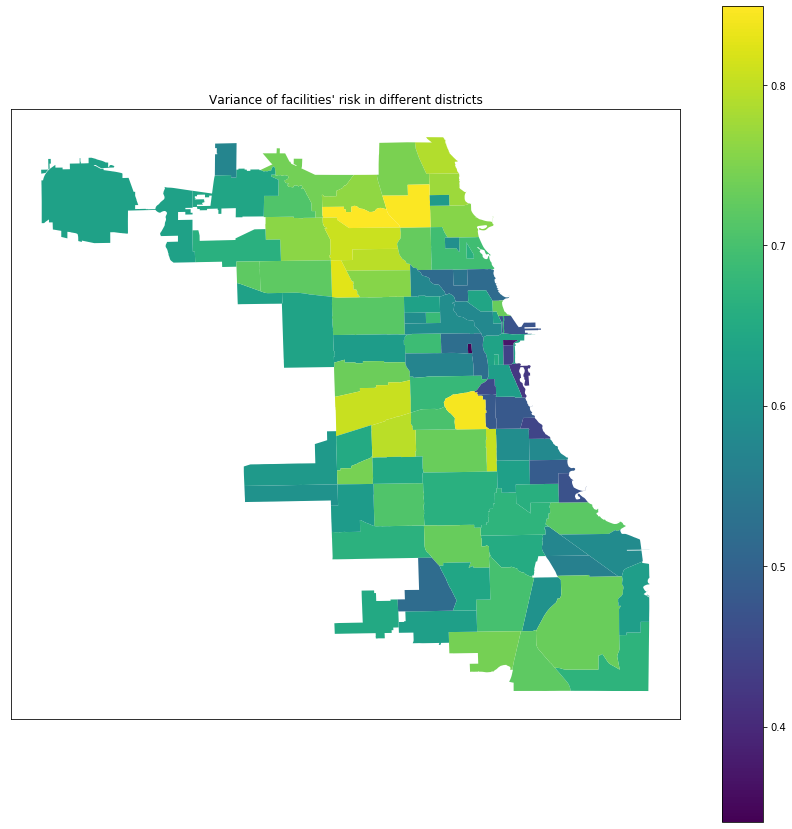

In [72]:
base = dist_risk.plot(column='mean',legend=True,figsize=(15, 15)) 
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator()) 
plt.title('Mean risk of facility in different districts')

base = dist_risk.plot(column='count',legend=True,figsize=(15, 15)) 
plt.gca().xaxis.set_major_locator(plt.NullLocator()) 
plt.gca().yaxis.set_major_locator(plt.NullLocator()) 
plt.title('Number of facility in different districts')

base = dist_risk.plot(column='variance',legend=True,figsize=(15, 15)) 
plt.gca().xaxis.set_major_locator(plt.NullLocator()) 
plt.gca().yaxis.set_major_locator(plt.NullLocator()) 
plt.title('Variance of facilities\' risk in different districts')

Above is the mean risk value in different districts, we haven't find anything interesting so far.

## Average Risks of Facility Types, Results and Inspection Types

[1.185168167616247, 1.9424395218401225, 1.114793699874384, 1.0059574468085106, 1.5852981969486823]


<BarContainer object of 5 artists>

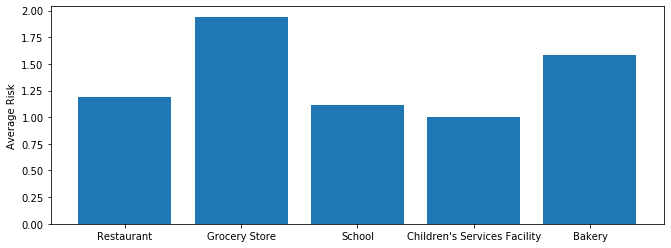

In [73]:
#Average risk for each facility type
Facilitylist = ['Restaurant','Grocery Store', 'School','Children\'s Services Facility', 'Bakery']
risksum = [0,0,0,0,0]; riskavg = [0,0,0,0,0]

for j in range(0,5):
    for i in range(1,len(DF)):
        if DF['Facility Type'][i] == Facilitylist[j]:
            if DF['Risk'][i] == 'Risk 1 (High)':
                risksum[j] = risksum[j] + 1
            if DF['Risk'][i] == 'Risk 2 (Medium)':
                risksum[j] = risksum[j] + 2
            if DF['Risk'][i] == 'Risk 3 (Low)':
                risksum[j] = risksum[j] + 3
    riskavg[j] = risksum[j]/fcounts[j]
print(riskavg)

fig = plt.figure(figsize=(11,4))
plt.ylabel('Average Risk')
plt.bar(Facilitylist,riskavg)

In the discussions below, higher risk means smaller value of Average Risk on the graph. vice versa

Among the five most common types of facilities, grocery stores and bakeries tend to have lower risks. Children's services facility has unexpectingly high risks, probably because the criteria of inspections is different or children are more vulnerable to food security problems.

[1.2817405911488247, 1.3600621555060397, 1.2431365103474463, 1.394859813084112]


<BarContainer object of 4 artists>

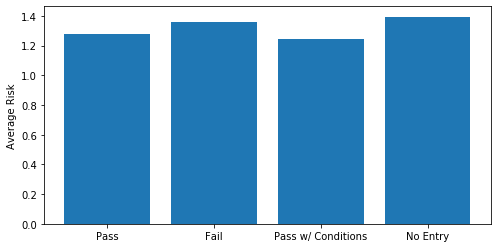

In [133]:
#Average risk for each result
Resultlist = ['Pass','Fail', 'Pass w/ Conditions','No Entry']
risksum = [0,0,0,0]; riskavg = [0,0,0,0]
for j in range(0,4):
    for i in range(1,len(DF)):
        if DF['Results'][i] == Resultlist[j]:
            if DF['Risk'][i] == 'Risk 1 (High)':
                risksum[j] = risksum[j] + 1
            if DF['Risk'][i] == 'Risk 2 (Medium)':
                risksum[j] = risksum[j] + 2
            if DF['Risk'][i] == 'Risk 3 (Low)':
                risksum[j] = risksum[j] + 3
    riskavg[j] = risksum[j]/rscounts[j]
print(riskavg)

fig = plt.figure(figsize=(8,4))
plt.ylabel('Average Risk')
plt.bar(Resultlist,riskavg)

It is interesting that the facilities which fail the inspections have lower risks compared with those that pass the inspections. In particular, the average risks of facilities that pass with conditions are the highest. It is possible that these conditions are designed for high risk facilities, and low risk facilities face stricter inspections.

[1.2267829328703113, 1.33119924121169, 1.5296189979123174, 1.2098782138024358, 1.3924145700337964, 1.4652977412731005, 1.562019758507135, 1.123926380368098]


<BarContainer object of 8 artists>

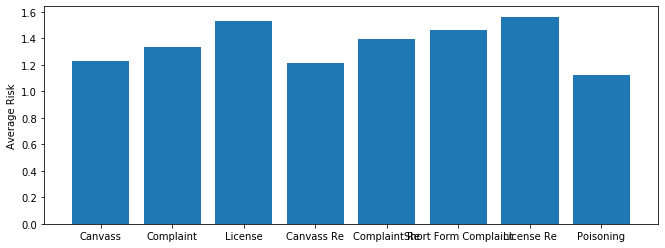

In [134]:
#Average risk for inspection types
Inspectlist = ['Canvass','Complaint', 'License','Canvass Re-Inspection','Complaint Re-Inspection','Short Form Complaint', \
              'License Re-Inspection','Suspected Food Poisoning']
risksum = [0,0,0,0,0,0,0,0]; riskavg = [0,0,0,0,0,0,0,0]
for j in range(0,8):
    for i in range(1,len(DF)):
        if DF['Inspection Type'][i] == Inspectlist[j]:
            if DF['Risk'][i] == 'Risk 1 (High)':
                risksum[j] = risksum[j] + 1
            if DF['Risk'][i] == 'Risk 2 (Medium)':
                risksum[j] = risksum[j] + 2
            if DF['Risk'][i] == 'Risk 3 (Low)':
                risksum[j] = risksum[j] + 3
    riskavg[j] = risksum[j]/ins_counts[j]
print(riskavg)

fig = plt.figure(figsize=(11,4))
plt.ylabel('Average Risk')
plt.bar(['Canvass','Complaint', 'License','Canvass Re','Complaint Re','Short Form Complaint','License Re','Poisoning'],riskavg)

On the whole, when re-inspected, a small portion of facilities are rated at lower risks. It can also be observed that facilities might get prepared purposely for license inspection, resulting in lower average risk. When inspected regularly or because of complaint, they perform much poorer. Additionly, it is conceivable that the facilities which are inspected because of poisoning tend to have the highest risks.

## Average Pass Rate of Each Inspection Type, Year and Month 

[0.7807879886627684, 0.6576560554863952, 0.5569545929018789, 0.8968200270635994, 0.8567405182125423, 0.8256673511293634, 0.7362788144895719, 0.7411042944785277]
re-inspection improvement =  0.13224807144214323


<BarContainer object of 8 artists>

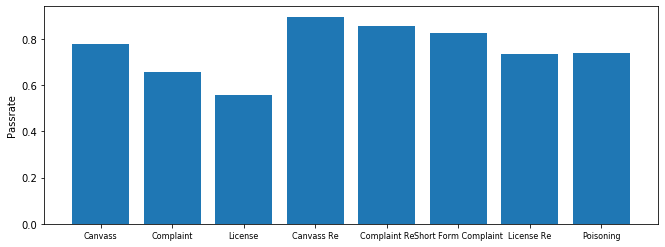

In [135]:
#passrate for inspection types
passrate = [0,0,0,0,0,0,0,0]; n_pass = passrate
for j in range(0,8):
    for i in range(1,len(DF)):
        if DF['Inspection Type'][i] == Inspectlist[j]:
            if DF['Results'][i] == 'Pass' or DF['Results'][i] == 'Pass w/ Conditions':
                n_pass[j] = n_pass[j] + 1
    passrate[j] = n_pass[j]/ins_counts[j]
print(passrate)
print('re-inspection improvement = ',(passrate[3]*ins_counts[3]+passrate[4]*ins_counts[4]+passrate[6]*ins_counts[6]) \
      /(ins_counts[3]+ins_counts[4]+ins_counts[6]) - (passrate[0]*ins_counts[0]+passrate[1]*ins_counts[1]+passrate[2]*ins_counts[2]) \
      /(ins_counts[0]+ins_counts[1]+ins_counts[2]))

fig = plt.figure(figsize=(11,4))
plt.tick_params(axis='x', labelsize=8)
plt.ylabel('Passrate')
plt.bar(['Canvass','Complaint', 'License','Canvass Re','Complaint Re','Short Form Complaint','License Re','Poisoning'],passrate)

In comparison with the average risks of each inspection type, the probabilities of passing an inspection (passrate) increase more obviously when it comes to re-inspection. The average passrate of re-inspections is 13% greater than that of the inspections before. Another difference worth noticing is that Risk(Canvass)<Risk(Complaint)<Risk(License) but Passrate(Canvass)>Passrate(Canvass)>Passrate(License), which coincides with the speculations that facilities with lower risks are harder to pass inspections

[0.7193168818434384, 0.7275464879921705, 0.7582207980468452, 0.7881647836869661, 0.7911706349206349, 0.7767787839586029, 0.7494313210848644, 0.7407925704471726, 0.74612118873022, 0.7502641775272983]


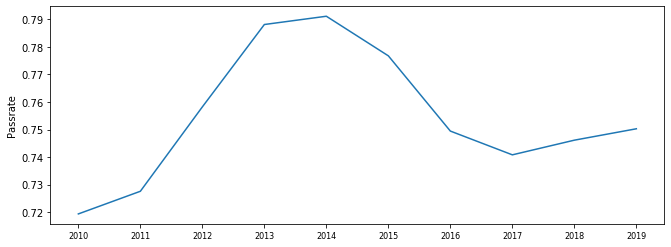

In [136]:
#passrate for each year
passrate = [0]*10; n_pass = [0]*10
yearlist = ['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']


for j in range(0,10):
    for i in range(1,len(DF)):
        if DF['year'][i] == yearlist[j]:
            if DF['Results'][i] == 'Pass' or DF['Results'][i] == 'Pass w/ Conditions':
                n_pass[j] = n_pass[j] + 1
    passrate[j] = n_pass[j]/ycounts[yearlist[j]]
print(passrate)

fig = plt.figure(figsize=(11,4))
plt.tick_params(axis='x', labelsize=8)
plt.ylabel('Passrate')
plt.plot(['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019'],passrate)

The passrate is generally stable with small changes over the years. However, to know whether the changes are long-term or merely fluctuations, datas of longer periods of time need to be investigated.

[0.7688556000696742, 0.7609039337859203, 0.7602127331586249, 0.7590692413347337, 0.765250222090613, 0.7554059109614665, 0.7435656584632726, 0.739096390259181, 0.73919899085462, 0.751616464280082, 0.7612787570959068, 0.775330396475771]


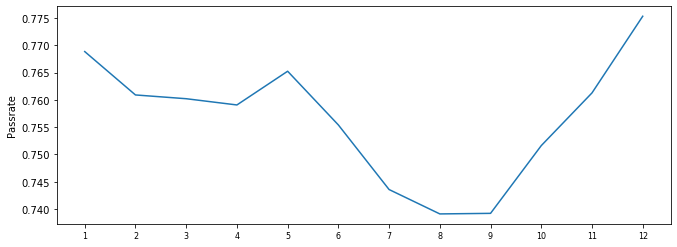

In [137]:
#passrate for each month
passrate = [0]*12; n_pass = [0]*12
monthlist = ['01','02','03','04','05','06','07','08','09','10','11','12']


for j in range(0,12):
    for i in range(1,len(DF)):
        if DF['month'][i] == monthlist[j]:
            if DF['Results'][i] == 'Pass' or DF['Results'][i] == 'Pass w/ Conditions':
                n_pass[j] = n_pass[j] + 1
    passrate[j] = n_pass[j]/mcounts[monthlist[j]]
print(passrate)

fig = plt.figure(figsize=(11,4))
plt.tick_params(axis='x', labelsize=8)
plt.ylabel('Passrate')
plt.plot(['1','2','3','4','5','6','7','8','9','10','11','12'],passrate)

## P-Value analysis of inspection results and average risk of each month

In [138]:
#Calculate the p-value of passrates of all months
monthpass = [[0] for i in range(12)]
for i in range(0,12):
    monthpass[i] = [1]*int(passrate[i]*mcounts[i]) + [0]*int((1-passrate[i])*mcounts[i])

f,p = stats.f_oneway(monthpass[0],monthpass[1],monthpass[2],monthpass[3],monthpass[4],monthpass[5], \
                    monthpass[6],monthpass[7],monthpass[8],monthpass[9],monthpass[10],monthpass[11],)
print('f=',f,'p=',p)

f= 8.044944171793057 p= 3.323312623504385e-14


The p-value of all the months is close to 0, meaning that the results of 12 months are not intercorrelated.

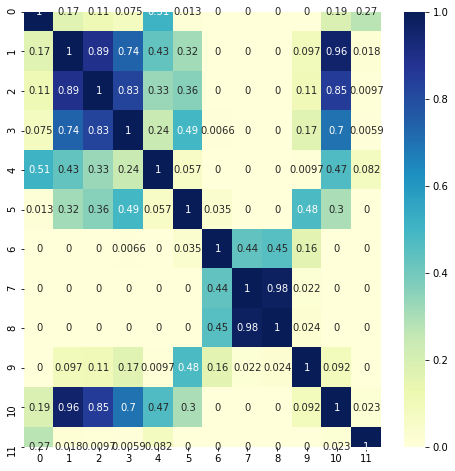

In [139]:
#plot the matrix of p-values between every two months
monthpass_p = [[0]*12 for i in range(12)]
for i in range(0,12):
    for j in range(0,12):
        f,p = stats.f_oneway(monthpass[i],monthpass[j])
        if np.isnan(p):
            p = 1.0
        if p < 0.005:
            p = 0
        monthpass_p[i][j] = p

fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(monthpass_p, cmap = 'YlGnBu', annot = True)

In general, adjacent months tend to have stronger correlations. Particularly, inspection results of months 1-3 (February, March, April) and months 6-8 (July, August, September) are correlated respectively. In addition, the results of month 10 (November) resemble that of February to May.

In [108]:
#obtain the numerical risks data of each month
DF_monthrisk['result_vector'] = None 
for i in range(12):
    DF_monthrisk['result_vector'][i] = np.concatenate((np.ones(DF_monthrisk['Risk 1 (High)'][i]), \
                                                       2*np.ones(DF_monthrisk['Risk 2 (Medium)'][i]), \
                                                       3*np.ones(DF_monthrisk['Risk 3 (Low)'][i])),axis = 0)

D:\anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [110]:
#Calculate the p-value of risks of all months
m_count = np.zeros((12,3),dtype=np.int)
for i in range(0,12):
    for j in range(0,3):
        m_count[i][j] = DF_monthrisk.iat[i,j]

f,p = stats.f_oneway(DF_monthrisk['result_vector'][3],DF_monthrisk['result_vector'][11])
print('f=',f,'p=',p)

f= 783.4473181216187 p= 2.725082430426594e-169


The p-value of all the months is close to 0, meaning that the risks of 12 months are not intercorrelated.

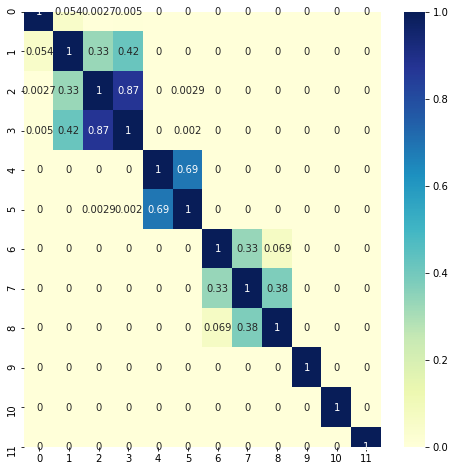

In [111]:
#plot the matrix of p-values between every two months
monthrisk_p = [[0]*12 for i in range(12)]
for i in range(0,12):
    for j in range(0,12):
        f,p = stats.f_oneway(DF_monthrisk['result_vector'][i],DF_monthrisk['result_vector'][j])
        if np.isnan(p):
            p = 1.0
        if p < 0.001:
            p = 0
        monthrisk_p[i][j] = p

fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(monthrisk_p, cmap = 'YlGnBu', annot = True)

Similarly, adjacent months tend to have stronger correlations. Average risks of months 1-3 (February, March, April), months 4-5 (May, June) and months 6-8 (July, August, September) are correlated respectively. In contrast, the risks of month 10 (November) don't resemble that of February to May. These two p-value graphs show that the results and risks of months reveal some clustering phenomena.

## Risk Analysis of Keywords with High Frequencies

In [143]:
#split the names of facilities and append them into a list
DF['name_words'] = None
DF['name_words'] = DF['AKA Name'].apply(lambda x:x.split(' '))

words_list = []
for i in range(1,len(DF)):
    words_list.append(DF['name_words'][i])

words_list = list(chain.from_iterable(words_list))
len(words_list)

416578

In [144]:
#drop the words with lengths shorter than 3
length = len(words_list)
delete_indices = []
words_list2 = []
for i in range(1,len(words_list)):
    if len(words_list[i]) <= 3:
        delete_indices.append(i)
for i in range(1,len(words_list)):
    if i not in delete_indices:
        words_list2.append(words_list[i])
len(words_list2)

328337

In [145]:
#obtain the most common-used words in facility names
count_words = Counter(words_list2).most_common(25)
DF_words = pd.DataFrame(count_words[0:25],columns=['key word','counts'])
DF_words.head(10)

,key word,counts
0,RESTAURANT,8367
1,FOOD,5789
2,CAFE,4775
3,GRILL,3799
4,INC.,3415
5,PIZZA,3396
6,SCHOOL,3352
7,SUBWAY,3099
8,MARKET,2956
9,CHICKEN,2738


In [146]:
#Calcualte the average risks given that certain common-used words appear in facility names
keywords = [0]*25
for i in range(0,25):
    keywords[i] = DF_words['key word'][i]

risksum = [0]*25; riskavg = [0]*25

for j in range(0,25):
    for i in range(1,len(DF)):
        if keywords[j] in DF['name_words'][i]:
            if DF['Risk'][i] == 'Risk 1 (High)':
                risksum[j] = risksum[j] + 1
            if DF['Risk'][i] == 'Risk 2 (Medium)':
                risksum[j] = risksum[j] + 2
            if DF['Risk'][i] == 'Risk 3 (Low)':
                risksum[j] = risksum[j] + 3
    riskavg[j] = risksum[j]/DF_words['counts'][j]
print(riskavg)

[1.0374088681725828, 1.7671445845569183, 1.1373821989528796, 1.081600421163464, 1.481112737920937, 1.2405771495877502, 1.1178400954653938, 1.0061310100032268, 1.4506089309878214, 1.570854638422206, 1.0424509411293552, 1.238762886597938, 1.4121376811594204, 1.0459446788560713, 1.118695873662761, 1.9920508744038157, 1.002212389380531, 1.0209276018099547, 1.1029579067121729, 2.1732644865174984, 1.8044890726520968, 1.962523422860712, 1.6900539707016191, 1.0, 1.6499602227525856]


<BarContainer object of 25 artists>

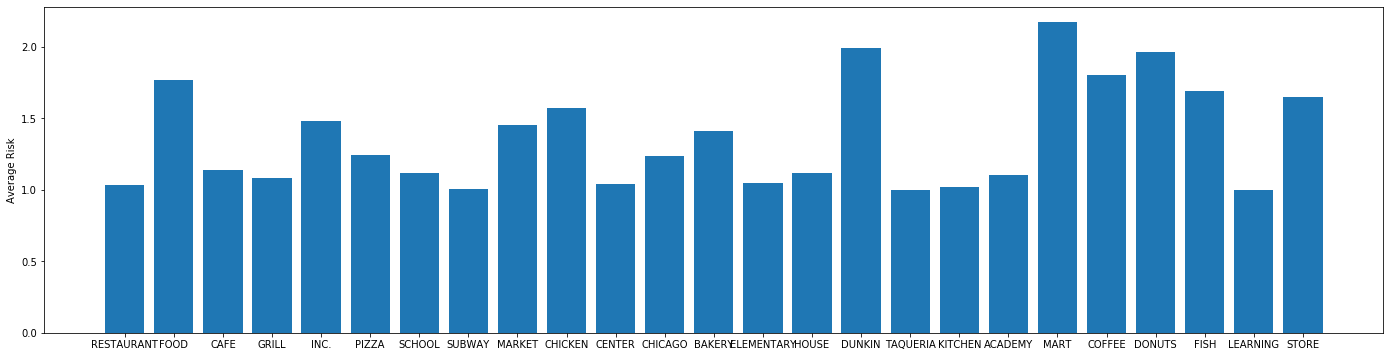

In [147]:
fig = plt.figure(figsize=(24,6))
plt.ylabel('Average Risk')
plt.bar(keywords,riskavg)

The average risks of facilities whose names contain certain keywords vary greatly. For example, if the words 'food','dunkin','mart','coffee','donuts','fish','store' appear in the names of facilities, these facilities might have lower risks. Interestingly, 8400 out of 98000 restaurants whose names contain the word 'restaurant' have much higher risks than average restaurants.

## Current faced problem and Further plane 

### Enrich of geo-related data

##### Problem:
We have ready projected all the restruant into a Chicago map, but the other district-related dataset we found have different name of communities.This makes it hart to linked the extra information to current one.

##### The plane:
To build a dictionary or find a dictionary amanually which contains all the possiable name of the communities. 


#### Important violations analysis

##### Problem:
The violation importance that we got through two different method are inconsistent. 

##### The plane:
At first will look ar these violations deeply, include the distribution and the actual meaning of these violations to try to do some interpratations. If we couldn't find any clue, we will just drop these violation features to train the model to see if there is significant difference between predict result within or without these violations.

#### geographical neighor facilities analysis

##### Problem:
We have ready projected facilities into different districts of Chicago, but it's still hard to find any partten from the neighbor facilities. 

##### The plane:
we are going to analysis the facilities within the certain distance of one facility to see if there are any interesting partten.

#### Risk prediction 
##### Problem:
We have already used logistic regression and random forest to predict risk by the violation, but no facility type information inclued and the accuracy is not so good as well.
##### Plane:
We noticed that there are differences risk mean among different type of facility.So,for a further plan, we want to also include facility to improve the model.


#### Passrate analysis among different risk level
##### Problem and plane
We find out that the mean passrate is lower in the good risk level facilities than in bad level facilities, this seems doesn't make sense, we want to find out why.


#### Risk distributions and Pass reult on time domain.

##### Problem and plane:
From initial analysis we can see that the distributions of risk and results have significant differences among time domin, we want to find out hidden reasons of this weird phenomenon.Is it because of the inspection type or facility type or other element.